# Minimum-Tracking-Error Frontier &  Minimum-Variance Frontier w/o Short Sales Simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
industry_portfolios = pd.read_excel('Industry_Portfolios.xlsx')
market_portfolio = pd.read_excel('Market_Portfolio.xlsx')
risk_factors = pd.read_excel('Risk_Factors.xlsx')

/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
industry_portfolios = industry_portfolios.set_index('Date')
industry_portfolios.head(1)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88


In [4]:
market_portfolio = market_portfolio.set_index('Date')
market_portfolio.head(1)

,Market
Date,
200401,2.22


## Part 1: Minimum-Tracking-Error Frontier

> Expected Return Deviations

In [5]:
R = []
for portfolio in industry_portfolios.columns:
    r = np.mean(industry_portfolios[portfolio] - market_portfolio['Market'])
    R.append(r)
table = pd.DataFrame(R, index = industry_portfolios.columns, columns = ['Expected_Deviation'])
table

,Expected_Deviation
NoDur,0.154750
Durbl,-0.014750
Manuf,0.264750
Enrgy,0.483083
HiTec,0.018167
Telcm,0.133333
Shops,0.168250
Hlth,0.035750
Utils,0.159083
Other,-0.259000


> Covariance Matrix of Return Deviations
$$V_{ij} = Cov[(\tilde{R_i}-\tilde{R_m})]$$

In [6]:
Return_Deviation = industry_portfolios.copy()
for portfolio in industry_portfolios.columns:
    Return_Deviation[portfolio] = Return_Deviation[portfolio] - market_portfolio['Market']
V = Return_Deviation.iloc[:, 0:10].cov()
V

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,5.439696,-6.073035,-1.396192,-1.200533,-1.883151,1.538885,1.140741,3.815137,4.272002,-1.768738
Durbl,-6.073035,26.628901,4.908024,-3.481055,1.891577,-1.707625,-0.354335,-8.082946,-9.617490,4.385865
Manuf,-1.396192,4.908024,2.950499,1.666133,0.065267,-0.626416,-1.154597,-2.288900,-1.901412,0.358904
Enrgy,-1.200533,-3.481055,1.666133,19.274911,-1.516972,-1.040525,-3.710439,-2.485796,4.454368,-3.864826
HiTec,-1.883151,1.891577,0.065267,-1.516972,5.098746,-0.773294,-0.245350,-1.936284,-2.342839,-1.404050
Telcm,1.538885,-1.707625,-0.626416,-1.040525,-0.773294,4.682567,0.463797,0.693157,2.721477,-1.271778
Shops,1.140741,-0.354335,-1.154597,-3.710439,-0.245350,0.463797,4.452628,0.764510,-0.176666,-0.256987
Hlth,3.815137,-8.082946,-2.288900,-2.485796,-1.936284,0.693157,0.764510,7.820446,3.496136,-1.726842
Utils,4.272002,-9.617490,-1.901412,4.454368,-2.342839,2.721477,-0.176666,3.496136,12.267476,-4.055112
Other,-1.768738,4.385865,0.358904,-3.864826,-1.404050,-1.271778,-0.256987,-1.726842,-4.055112,4.503204


>Standard Deviation of Return Deviations

In [7]:
table['Std_Deviation'] = Return_Deviation.iloc[:, 0:10].std()
table

,Expected_Deviation,Std_Deviation
NoDur,0.154750,2.332316
Durbl,-0.014750,5.160320
Manuf,0.264750,1.717702
Enrgy,0.483083,4.390320
HiTec,0.018167,2.258040
Telcm,0.133333,2.163924
Shops,0.168250,2.110125
Hlth,0.035750,2.796506
Utils,0.159083,3.502496
Other,-0.259000,2.122075


>Minimum-Tracking-Error Frontier
$$\sigma_{i-m}^2 = w'Vw =\frac{1}{\delta}+\frac{\delta}{\zeta\delta-\alpha^2}(R_p - R_{mv})^2$$
$$R_p = R_{mv} \pm (\zeta-\frac{\alpha^2}{\delta})^\frac{1}{2}\sigma_p$$
*Where*
$$\alpha = R_{i-m}'V^{-1}e$$
$$\zeta = R_{i-m}'V^{-1}R_{i-m}$$
$$\delta = e'V^{-1}e$$
$$R_{mv} = \frac{\alpha}{\delta}$$

In [8]:
# Create V', e
inversed_V = np.linalg.inv(V)
e = pd.Series(np.ones(10))

# Calculate alpha, zeta, and delta
alpha = np.dot(np.dot(table.Expected_Deviation.T, inversed_V), e)
zeta = np.dot(np.dot(table.Expected_Deviation.T, inversed_V), table.Expected_Deviation)
delta = np.dot(np.dot(e.T, inversed_V), e)

#Produce Rmv
Rmv = alpha/delta

print('alpha = ', str(alpha), '\n', 'zeta = ', str(zeta), '\n','delta = ', str(delta), '\n', 'Rmv = ', str(Rmv))

alpha =  2.932127882630625 
 zeta =  0.20474497351130078 
 delta =  58.55025437639894 
 Rmv =  0.05007882397540084


In [9]:
# Calculate variance of return deviation of portfolios with Rp range from 0% to 0.1%
def minimum_tracking_error_frontier(Rp):
    variance_of_return_deviation = 1/delta + (delta / (delta * zeta - pow(alpha, 2))) * pow(Rp - Rmv, 2)
    tracking_error = pow(variance_of_return_deviation, 0.5)
    return tracking_error

Rp = np.arange(0, 0.105, 0.005)
tracking_error = []
for rp in Rp:
    std = minimum_tracking_error_frontier(rp)
    tracking_error.append(std)
    
minimum_tracking_error_frontier_data = pd.DataFrame([list(Rp), 
                                                    tracking_error], 
                                                    ['Expected Return Deviation', 'Tracking Error']).T
minimum_tracking_error_frontier_data 

,Expected Return Deviation,Tracking Error
0,0.000,0.245740
1,0.005,0.228411
2,0.010,0.211704
3,0.015,0.195778
4,0.020,0.180840
5,0.025,0.167154
6,0.030,0.155053
7,0.035,0.144934
8,0.040,0.137235
9,0.045,0.132381


Text(0, 0.5, 'Tracking Error (%)')

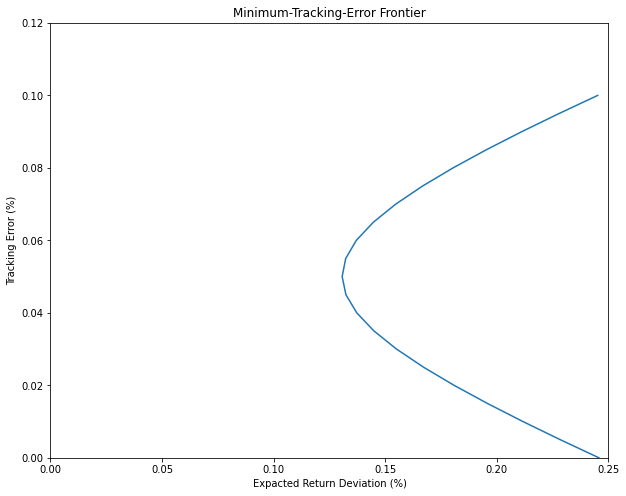

In [10]:
# Plot Minimum-Tracking-Error Frontier
plt.figure(figsize = (10, 8))
plt.plot('Tracking Error', 'Expected Return Deviation', data = minimum_tracking_error_frontier_data, linestyle = '-')
plt.title('Minimum-Tracking-Error Frontier')
plt.xlabel('Expacted Return Deviation (%)')
plt.xlim(0, 0.25)
plt.ylim(0, 0.12)
plt.ylabel('Tracking Error (%)')

## Tangent Portfolio

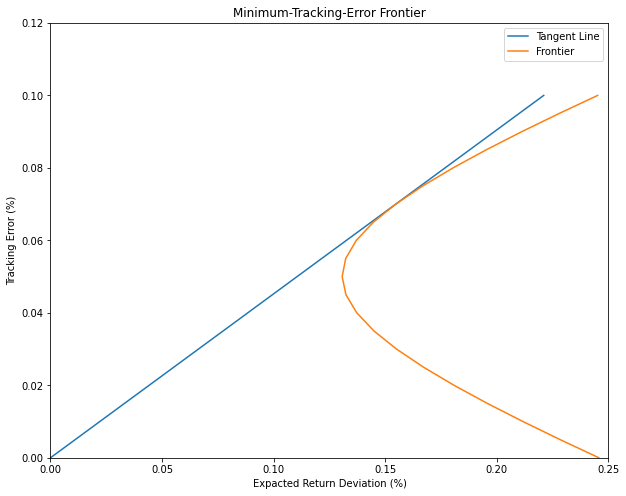

In [11]:
# Generate standard deviation of return deviation
def tangent_line(r):
    tracking_error = (r - 0)**2 / (zeta - 2*alpha*0 + delta*(0**2))
    standard_deviation_of_return_deviation = tracking_error**0.5
    return standard_deviation_of_return_deviation

std_of_return_deviation = []
for rp in minimum_tracking_error_frontier_data['Expected Return Deviation']:
    std = tangent_line(rp)
    std_of_return_deviation.append(std)
minimum_tracking_error_frontier_data['Tracking Error 2'] = std_of_return_deviation

#Plot Minimun-Tracking-Error Frontier with Tangent Line starting from the Origin
plt.figure(figsize = (10, 8))
plt.plot('Tracking Error 2', 'Expected Return Deviation', data = minimum_tracking_error_frontier_data, label = 'Tangent Line')
plt.plot('Tracking Error', 'Expected Return Deviation', data = minimum_tracking_error_frontier_data, label = 'Frontier')
plt.title('Minimum-Tracking-Error Frontier')
plt.xlabel('Expacted Return Deviation (%)')
plt.xlim(0, 0.25)
plt.ylim(0, 0.12)
plt.ylabel('Tracking Error (%)')
plt.legend()
plt.show();

$$R_{tg}=R_{mv} - \frac{\zeta\delta - \alpha^2}{\delta^2(-R_{mv})}$$

In [12]:
R_tg = Rmv-(zeta*delta-alpha**2)/(delta**2*(-Rmv))
R_tg

0.06982811859065614

$$\sigma_{tg} = \frac{1}{\delta} + \frac{\delta(R_{tg}-R_{mv})^2}{\zeta\delta - \alpha^2}$$

In [13]:
sigma_tg = (1/delta + (delta*(R_tg-Rmv)**2)/(zeta*delta - alpha**2))**0.5
sigma_tg

0.15432053366443688

*Slope of tangent line is **Information Ratio** of tangent portfolio* 
$$I_{tg}=\frac{E(\tilde{R_{tg}}-\tilde{R_m})}{\sqrt{Var(\tilde{R_{tg}}-\tilde{R_m})}}=\frac{R_{tg}}{\sigma_{tg}}$$

In [14]:
Information_Ratio = R_tg/sigma_tg
Information_Ratio

0.4524875396199334

**The tangency portfolio weights for the ten industry portfolios.**
$$w^* = \lambda_{tg} V^{-1}R$$
*Where*$$\lambda_{tg} = \frac{R_{tg}}{\zeta}$$

In [15]:
lambda_tg = R_tg/zeta
tangency_portfolio_weights = np.dot(lambda_tg*inversed_V, table.Expected_Deviation)
weights = pd.DataFrame(tangency_portfolio_weights, index = table.index, columns =['Weights'])
weights

,Weights
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


## Part II Minimum-Variance Frontier w/o Short Sales

In [16]:
table['Mean_Return'] = industry_portfolios.iloc[:, 0:10].mean()
table

,Expected_Deviation,Std_Deviation,Mean_Return
NoDur,0.154750,2.332316,0.902833
Durbl,-0.014750,5.160320,0.733333
Manuf,0.264750,1.717702,1.012833
Enrgy,0.483083,4.390320,1.231167
HiTec,0.018167,2.258040,0.766250
Telcm,0.133333,2.163924,0.881417
Shops,0.168250,2.110125,0.916333
Hlth,0.035750,2.796506,0.783833
Utils,0.159083,3.502496,0.907167
Other,-0.259000,2.122075,0.489083


In [17]:
portfolios_V = industry_portfolios.iloc[:, 0:10].cov()
portfolios_V

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,11.193422,18.449666,14.104907,10.531341,12.922949,11.968078,10.170832,9.953112,7.866653,14.438409
Durbl,18.449666,69.920577,39.178097,27.019794,35.466652,27.490543,27.444731,16.824003,12.746136,39.361987
Manuf,14.104907,39.178097,28.198970,23.145380,24.618739,19.550150,17.622867,13.596447,11.440612,26.313423
Enrgy,10.531341,27.019794,23.145380,36.984933,19.267276,15.366817,11.297800,9.630327,14.027168,18.320469
HiTec,12.922949,35.466652,24.618739,19.267276,28.957220,18.708273,17.837115,13.254064,10.304187,23.855470
Telcm,11.968078,27.490543,19.550150,15.366817,18.708273,19.787227,14.169356,11.506599,10.991596,19.610836
Shops,10.170832,27.444731,17.622867,11.297800,17.837115,14.169356,16.759084,10.178849,6.694350,19.226524
Hlth,9.953112,16.824003,13.596447,9.630327,13.254064,11.506599,10.178849,14.342669,7.475036,14.864553
Utils,7.866653,12.746136,11.440612,14.027168,10.304187,10.991596,6.694350,7.475036,13.703052,9.992960
Other,14.438409,39.361987,26.313423,18.320469,23.855470,19.610836,19.226524,14.864553,9.992960,31.163771


> **Simulate w Following Uniform Distribution**

In [18]:
mean_return = []
std_deviation_of_return = []
def simulated_portfolio(times):
    for i in range(times):
        w0 = np.random.uniform(size = 10)
        w = w0/sum(w0)
        mean_return.append(np.sum(table.Mean_Return*w))
        std_deviation_of_return.append((np.dot(np.dot(w.T, portfolios_V), w)**0.5))
    return mean_return, std_deviation_of_return

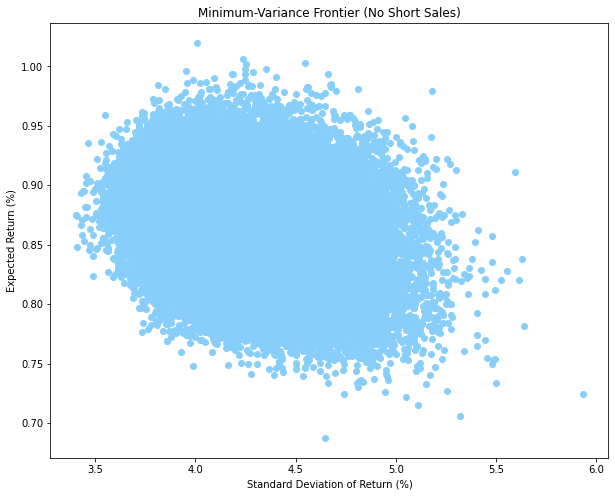

In [19]:
plt.figure(figsize = (10, 8))
mean_return, std_deviation_of_return = simulated_portfolio(100000)
plt.scatter(std_deviation_of_return, mean_return, color = 'lightskyblue', marker = 'o')
plt.title('Minimum-Variance Frontier (No Short Sales)')
plt.xlabel('Standard Deviation of Return (%)')
plt.ylabel('Expected Return (%)')
plt.show()

>**Simulate 1/w**

In [20]:
mean_return = []
std_deviation_of_return = []
def simulated_portfolio_2(times):
    for i in range(times):
        w0 = 1/np.random.uniform(size = 10)
        w = w0/sum(w0)
        mean_return.append(np.sum(table.Mean_Return*w))
        std_deviation_of_return.append((np.dot(np.dot(w.T, portfolios_V), w)**0.5))
    return mean_return, std_deviation_of_return

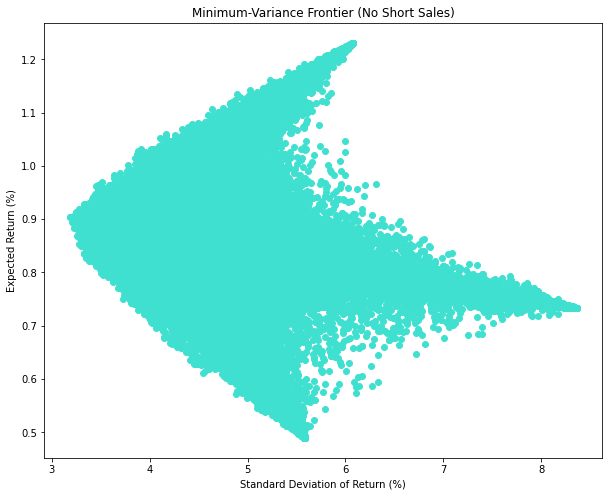

In [22]:
plt.figure(figsize = (10, 8))
mean_return, std_deviation_of_return = simulated_portfolio_2(100000)
plt.scatter(std_deviation_of_return, mean_return, color = 'turquoise')
plt.title('Minimum-Variance Frontier (No Short Sales)')
plt.xlabel('Standard Deviation of Return (%)')
plt.ylabel('Expected Return (%)')
plt.show()